In [77]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit

In [2]:
train_split ='train[:80%]'
test_split ='train[80%:]'
batch_size= 1000
dataset_name = 'ku_luven_td/5s_sub16'
(ds_train, ds_test), dataset_info = tfds.load(dataset_name, split=[train_split, test_split], shuffle_files=False,with_info=True,)

ds_train= ds_train.cache().shuffle(dataset_info.splits[train_split].num_examples).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2023-08-09 01:30:37.330629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 01:30:37.360258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 01:30:37.360302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 01:30:37.367581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 01:30:37.367653: I tensorflow/compile

In [3]:
x = next(iter(ds_train))

2023-08-09 01:30:39.190656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
2023-08-09 01:30:39.191397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]


In [4]:
label_gender = x['att_gender'].numpy()
data = x['eeg'].numpy()
data_0 = data[label_gender==0]
data_1 = data[label_gender==1]
B, T, C = data.shape
B_0, T0, C_0 = data_0.shape
B_1, T1, C_1 = data_1.shape
data_0 = data_0.transpose(2,0,1).reshape(C,-1)
data_1 = data_1.transpose(2,0,1).reshape(C,-1)

In [5]:
data_0.shape

(66, 74880)

In [6]:
c_0 = np.cov(data_0)
c_1 = np.cov(data_1)

In [7]:
c_0 = data_0@data_0.T/np.trace(data_0@data_0.T)
c_1 = data_1@data_1.T/np.trace(data_1@data_1.T)

In [8]:
c = c_0+c_1
eigvals, eigvecs = np.linalg.eig(c)
eigvals = np.abs(eigvals)
#eigvecs = eigvecs / np.max(np.abs(eigvecs), axis=0)

In [9]:
# sorted_indices = np.argsort(eigvals)[::-1]
# sorted_eigvecs = eigvecs[:, sorted_indices]
# sorted_eigvals = eigvals[sorted_indices]

In [10]:

p = np.diag(1/np.sqrt(eigvals+np.finfo(float).eps) ) @eigvecs.T
c_0p = p@c_0@p.T
c_1p = p@c_1@p.T

In [11]:
eigvals_0p, eigvecs_0p = np.linalg.eig(c_0p)
eigvals_1p, eigvecs_1p = np.linalg.eig(c_1p)

In [12]:
data_train = data.transpose(0,2,1).astype(np.float64)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
pl = Pipeline([("CSP", csp)]
pl(data_train)

SyntaxError: invalid syntax (3679990333.py, line 4)

In [3]:

data_train = data.transpose(0,2,1).astype(np.float64)
labels = label_gender
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data_train)

lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=32, reg=None, log=True, norm_trace=False)
svc = SVC(C=1, kernel='linear')

clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, data_train, labels, cv=cv, n_jobs=None,verbose=0)
print(scores)

NameError: name 'data' is not defined

In [14]:
X_csp = csp.fit_transform(data_train, y=labels)

Computing rank from data with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 66 dim * 1.7e+16  max singular value)
    Estimated rank (mag): 66
    MAG: rank 66 computed from 66 data channels with 0 projectors
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 66 dim * 2.4e+16  max singular value)
    Estimated rank (mag): 66
    MAG: rank 66 computed from 66 data channels with 0 projectors
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.


In [15]:
scores

array([0.77083333, 0.83333333, 0.78125   , 0.86458333, 0.8125    ,
       0.77083333, 0.77083333, 0.77083333, 0.79166667, 0.67708333])

In [16]:
X_csp.shape

(480, 32)

In [19]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

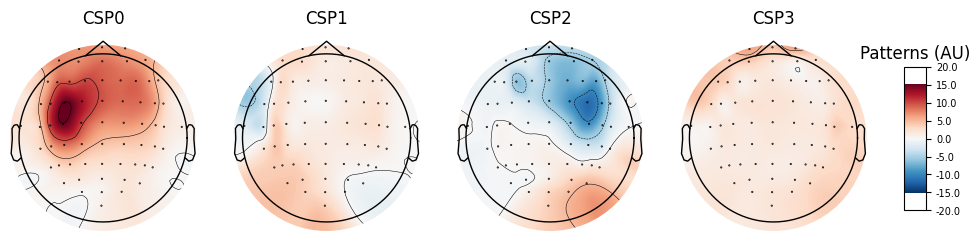

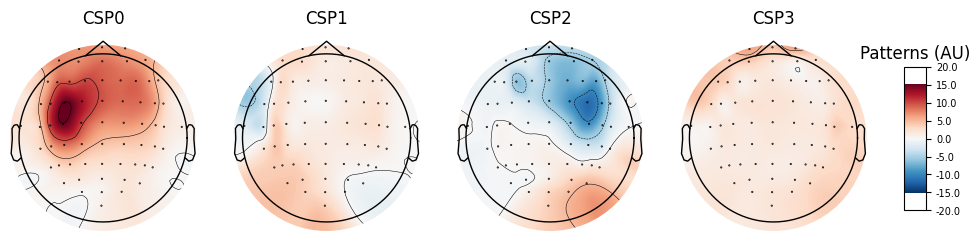

In [20]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [30]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

/home/alialavi/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alialavi/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (46,) and (1,)

In [29]:
X_test.shape

(9, 4)

In [22]:
epochs_data_train.shape

(45, 64, 161)

In [23]:
epochs_data_train.shape

(45, 64, 161)

In [24]:
scores

array([0.88888889, 1.        , 1.        , 0.88888889, 1.        ,
       0.88888889, 1.        , 1.        , 0.77777778, 0.88888889])

In [62]:
import scipy.io
import os
base_path ="/home/alialavi/datasets/eeg_den"

fn_chan = os.path.join(base_path,'data/chan.mat' )
subject = 1
fn_eeg = os.path.join(base_path, f'data/DATA_preproc/S{subject}_data_preproc.mat')
f_eeg = scipy.io.loadmat(fn_eeg)

eeg = f_eeg['data']['eeg'][0, 0]

In [63]:
eeg.shape

(1, 60)

In [21]:
x1 = np.random.normal(size=(200,66))
x2 = np.random.normal(size=(200,66))
x = np.array([x1,x2])

In [23]:
x =[x1,x2]

In [26]:
np.asarray(x).shape

(2, 200, 66)

In [37]:
np.asarray(fsample_eeg[0,0][0,:]).flatten().shape

(3200,)

In [41]:
fsample_eeg[0,0][0,:].dtype

dtype('O')

In [42]:
def flatten_nested(obj):
    if isinstance(obj, list):
        return [item for sublist in obj for item in flatten_nested(sublist)]
    else:
        return [obj]
    
flattened_array = flatten_nested(fsample_eeg[0,0][0,:])

In [134]:
np.asarray(expinfo['wavfile_male'])[0]

'aske_story4_trial_1.wav'

In [66]:
sh = eeg[0,9].shape
eeg_all = np.zeros((eeg.shape[1], *sh))
for i in range(eeg[0,:].shape[0]):
    eeg_all[i,...] = eeg[0,i]
eeg_all = eeg_all.transpose(0,2,1)    

In [67]:
eeg_all.shape

(60, 66, 3200)

In [61]:
f_eeg['data']['eeg'][0,0].shape

(1, 60)

In [102]:
import pandas as pd
fn_expinfo = os.path.join(base_path, f'data/EEG/s{subject}_expinfo.txt')
expinfo = pd.read_csv(fn_expinfo, delimiter=' ')
expinfo = expinfo[expinfo['n_speakers'] == 2].reset_index()

In [103]:
event_mf_all=np.asarray(expinfo['attend_mf']).reshape(-1) - 1

In [108]:
csp = CSP(n_components=30, reg=None, log=True, norm_trace=False)
eeg_all_transformed = csp.fit_transform(eeg_all, event_mf_all)

Computing rank from data with rank=None
    Using tolerance 2.2e+02 (2.2e-16 eps * 66 dim * 1.5e+16  max singular value)
    Estimated rank (mag): 65
    MAG: rank 65 computed from 66 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 66 -> 65
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e+03 (2.2e-16 eps * 66 dim * 6.8e+16  max singular value)
    Estimated rank (mag): 65
    MAG: rank 65 computed from 66 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 66 -> 65
Estimating covariance using EMPIRICAL
Done.


In [146]:
n_sections = 10
eeg_reshaped = eeg_all.reshape((eeg_all.shape[0]*n_sections,eeg_all.shape[1],eeg_all.shape[2]//n_sections))
events_mf_reshaped = np.repeat(event_mf_all, n_sections)
eeg_all_transformed.shape

In [182]:
import mne
fn_chan = os.path.join(base_path,'data/chan.mat' )
f_chan_names = scipy.io.loadmat(fn_chan)
ch_names = []
for i in range(64):
    ch_names.append(f_chan_names['x'][i, 0][0])

epochs=mne.EpochsArray(eeg_reshaped[:,:64,:], info=mne.create_info(ch_names=ch_names, sfreq=64,ch_types='eeg'))
epochs.set_montage('standard_1020')

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


Number of events,600
Events,1: 600
Time range,0.000 – 4.984 s
Baseline,off


In [217]:
X = eeg_reshaped[:,:64,:]  # X has shape (n_epochs, n_channels, n_times)
y = events_mf_reshaped  # Labels

# Apply CSP while keeping the rank of the input data
csp = CSP(n_components=4, reg='ledoit_wolf', rank='full')  # You can adjust the number of components
csp.transform_into = 'csp_space'
csp.fit(X, y)

# Transform the data using CSP
X_csp = csp.transform(X)

# Now X_csp contains the CSP-transformed data
print(X_csp.shape)  # Output shape: (n_epochs, n_components, n_times)

Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
(600, 4, 320)


In [216]:
csp.transform_into 

'average_power'

/tmp/ipykernel_2200/923208610.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  csp.plot_filters(epochs.info, scalings=1e-9)


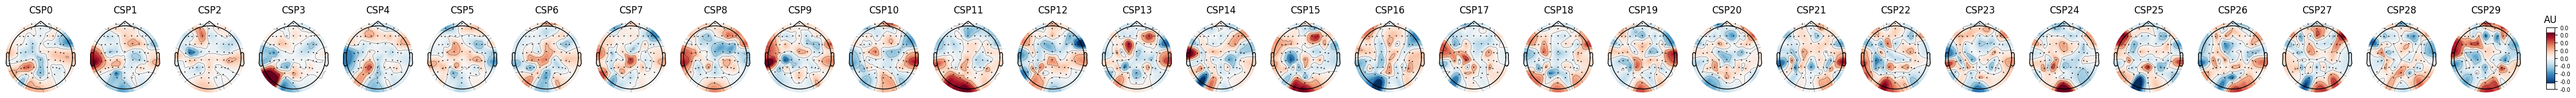

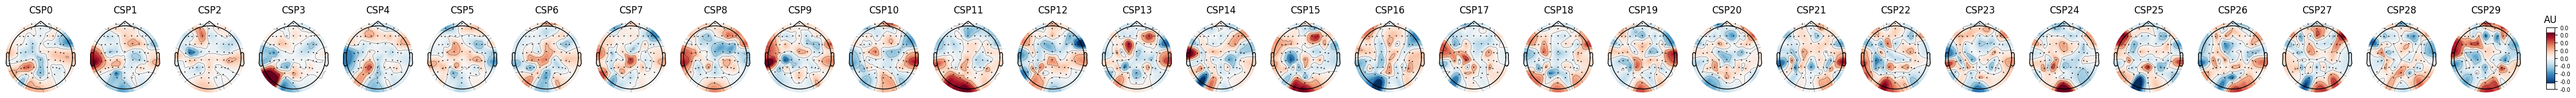

In [183]:
csp.plot_filters(epochs.info, scalings=1e-9)

In [202]:
csp = CSP(n_components=50, reg=None, log=True, norm_trace=False, rank='full')
csp.transform_into == 'csp_space'
csp.fit(eeg_reshaped[:,:64,:], events_mf_reshaped)

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(eeg_reshaped)

svc = SVC(C=1, kernel='linear')

#clf = Pipeline([('CSP', csp), ('SVC', svc)])
# clf = Pipeline([('SVC', svc)])
clf = Pipeline([('CSP', csp), ('SVC', LogisticRegression(solver="liblinear"))])
scores = cross_val_score(clf, eeg_reshaped, events_mf_reshaped, cv=cv, n_jobs=None,verbose=0)
print(scores)

Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 66 from info
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 66 from info
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 66 from info
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 66 from info
Reducing data rank from 66 -> 66
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 66 from info
Reducing data rank from 66 -> 66
Estimating covariance 

In [101]:
print(scores)

[0.60833333 0.69166667 0.65833333 0.64166667 0.68333333 0.64166667
 0.7        0.73333333 0.75       0.75      ]


In [122]:
print(scores)

[0.72       0.70833333 0.69833333 0.70333333 0.68       0.72666667
 0.71333333 0.72166667 0.72666667 0.725     ]


In [135]:
eeg_all_transformed.shape

(600, 30)

In [188]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

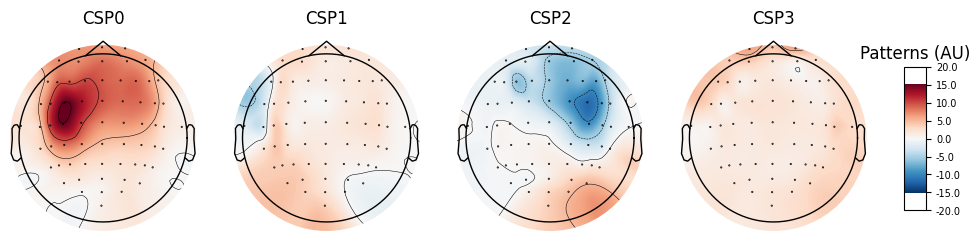

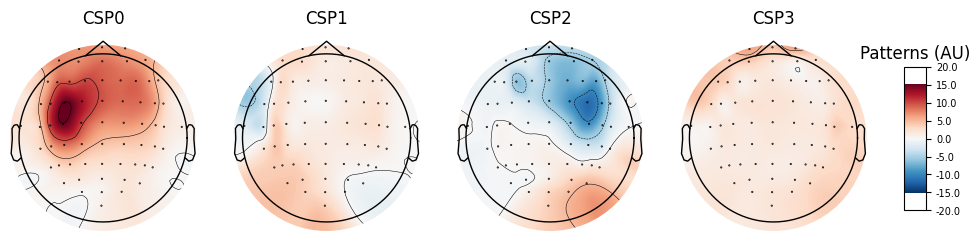

In [189]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [192]:
csp.transform(epochs_data).shape

(45, 4)

In [193]:
epochs_data.shape

(45, 64, 801)

In [205]:
import mne
from mne.decoding import CSP

# Load the EEGBCI Motor Movement/Imagery dataset
raw = mne.datasets.eegbci.load_data(subject=1, runs=[6])[0]
events, _ = mne.events_from_annotations(raw)

# Create epochs
event_id = dict(left_hand=2, right_hand=3)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1, tmax=4, baseline=None, preload=True)

# Get the data and labels from epochs
X = epochs.get_data()  # X has shape (n_epochs, n_channels, n_times)
y = epochs.events[:, -1]  # Labels

# Apply CSP while keeping the rank of the input data
csp = CSP(n_components=4, reg='ledoit_wolf', rank='full')  # You can adjust the number of components
csp.fit(X, y)

# Transform the data using CSP
X_csp = csp.transform(X)

# Now X_csp contains the CSP-transformed data
print(X_csp.shape)  # Output shape: (n_epochs, n_components, n_times)


AttributeError: 'PosixPath' object has no attribute 'annotations'

Automatically created module for IPython interactive environment
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/alialavi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 

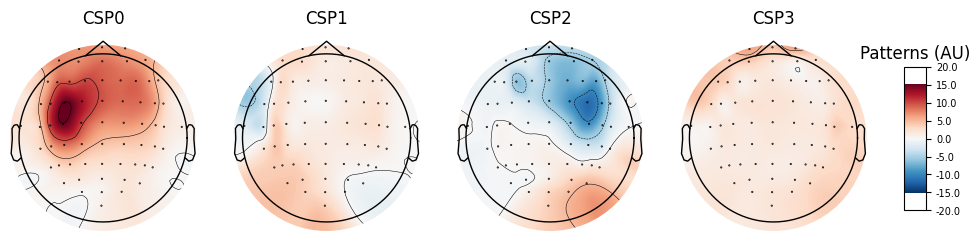

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


ValueError: Found array with dim 3. LinearDiscriminantAnalysis expected <= 2.

In [218]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2


# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)


sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []
csp.transform_into = 'csp_space'

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])
    # fit classifier
    lda.fit(X_train, y_train)
    break

In [208]:
X_train.shape

(36, 4)

In [209]:
epochs_data_train[train_idx].shape

(36, 64, 161)

In [223]:
a = np.arange(6).reshape((2,3))
b = np.repeat(a,4,axis=0)
b.shape

(8, 3)

In [224]:
b

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [3, 4, 5],
       [3, 4, 5],
       [3, 4, 5],
       [3, 4, 5]])